In [25]:
# # Cell 1: Install Dependencies
# %pip install -q sentence-transformers scikit-learn chromadb matplotlib

In [26]:
# Cell 2: Import Libraries
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import random
import joblib
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist

In [ ]:

#Cell 3: Load the full dataset
data = pd.read_csv("resume_screening_train.csv")

# Use only 25% of the full dataset
data_subset = data.sample(random_state=42).reset_index(drop=True)

# Split the 25% subset into train and test (50/50 split)
train, test = train_test_split(data_subset, test_size=0.5, random_state=42)

# Reset indices
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

# Print information
print(f"Total dataset: {len(data)} samples")
print(f"Subset used (25%): {len(data_subset)} samples")
print(f"Training data: {len(train)} samples ({len(train)/len(data)*100:.1f}% of total)")
print(f"Testing data: {len(test)} samples ({len(test)/len(data)*100:.1f}% of total)")

# Concatenate Role and Job Description
train['role_jobdesc'] = train['Role'] + " " + train['Job_Description']
test['role_jobdesc'] = test['Role'] + " " + test['Job_Description']

Total dataset: 10174 samples
Subset used (25%): 5087 samples
Training data: 2543 samples (25.0% of total)
Testing data: 2544 samples (25.0% of total)


In [ ]:
# Cell 4: Load SBERT and Encode Training Data
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Encode training data
print("Encoding training data...")
role_jobdesc_embeddings_train = model.encode(train['role_jobdesc'].tolist(), show_progress_bar=True)
resume_embeddings_train = model.encode(train['Job'].tolist(), show_progress_bar=True)

# For clustering, use only job description embeddings
X_train_embeddings = role_jobdesc_embeddings_train

print(f"Training embeddings shape: {X_train_embeddings.shape}")

Encoding training data...


Batches: 100%|██████████| 80/80 [01:11<00:00,  1.11it/s]


Training embeddings shape: (2543, 384)


Testing k values from 2 to 19...


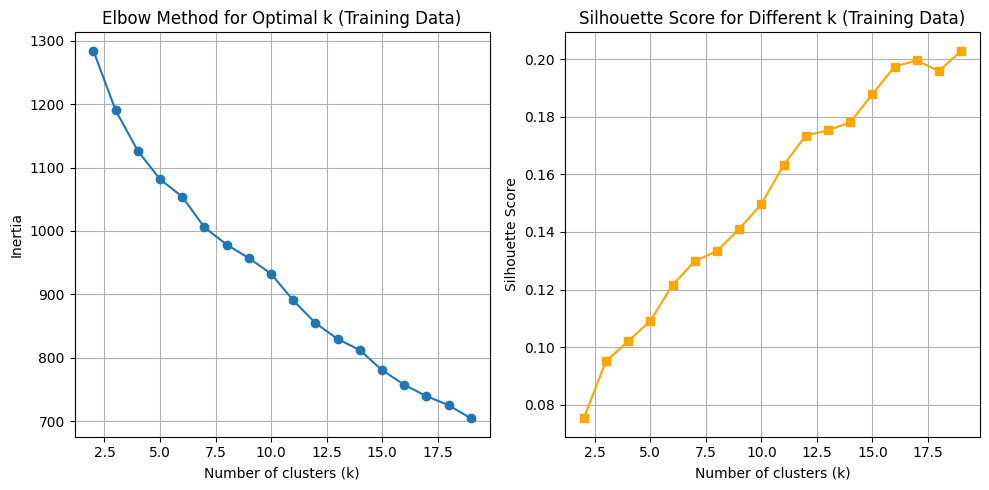

Best k selected: 19 (Training Silhouette Score: 0.2029)


In [29]:
# Cell 5: Elbow Method to Determine Best k (using training data only)
inertias = []
k_values = range(2, min(20, len(X_train_embeddings)//2))

print(f"Testing k values from {min(k_values)} to {max(k_values)}...")

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_embeddings)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values, inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k (Training Data)')
plt.grid(True)

# Calculate silhouette scores on training data
silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_train_embeddings)
    score = silhouette_score(X_train_embeddings, labels)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker='s', color='orange')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different k (Training Data)')
plt.grid(True)
plt.tight_layout()
plt.show()

best_k = k_values[np.argmax(silhouette_scores)]
print(f"Best k selected: {best_k} (Training Silhouette Score: {max(silhouette_scores):.4f})")

In [30]:
# Cell 6: Train Final K-Means Model (on training data only)
print(f"Training K-means with k={best_k} on {len(X_train_embeddings)} training samples...")
kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans.fit(X_train_embeddings)
print("K-means training completed!")

Training K-means with k=19 on 2543 training samples...
K-means training completed!


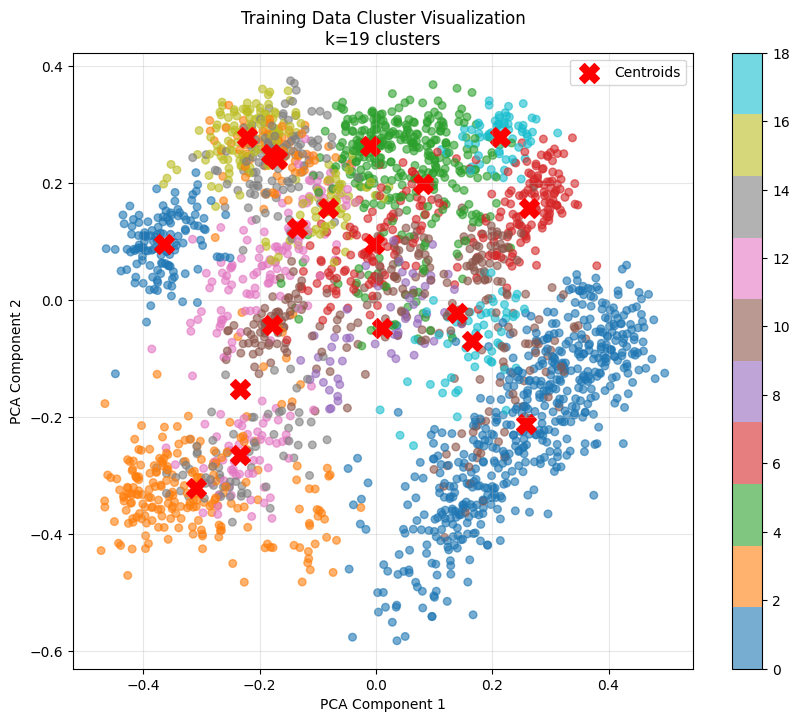


Training Cluster Distribution:
Cluster 0: 538 samples (21.2%)
Cluster 1: 131 samples (5.2%)
Cluster 2: 223 samples (8.8%)
Cluster 3: 75 samples (2.9%)
Cluster 4: 122 samples (4.8%)
Cluster 5: 215 samples (8.5%)
Cluster 6: 110 samples (4.3%)
Cluster 7: 134 samples (5.3%)
Cluster 8: 55 samples (2.2%)
Cluster 9: 67 samples (2.6%)
Cluster 10: 204 samples (8.0%)
Cluster 11: 107 samples (4.2%)
Cluster 12: 73 samples (2.9%)
Cluster 13: 71 samples (2.8%)
Cluster 14: 110 samples (4.3%)
Cluster 15: 66 samples (2.6%)
Cluster 16: 117 samples (4.6%)
Cluster 17: 66 samples (2.6%)
Cluster 18: 59 samples (2.3%)

Average Intra-cluster Euclidean Distances:
Cluster 0: 0.5828
Cluster 1: 0.5322
Cluster 2: 0.5686
Cluster 3: 0.3616
Cluster 4: 0.4822
Cluster 5: 0.5566
Cluster 6: 0.5434
Cluster 7: 0.4410
Cluster 8: 0.4237
Cluster 9: 0.4157
Cluster 10: 0.5582
Cluster 11: 0.5555
Cluster 12: 0.4697
Cluster 13: 0.4335
Cluster 14: 0.5572
Cluster 15: 0.3796
Cluster 16: 0.4280
Cluster 17: 0.3595
Cluster 18: 0.4278



In [31]:
# Cell 7: Training Data Cluster Visualization
pca = PCA(n_components=2)
train_2d = pca.fit_transform(X_train_embeddings)

# Get cluster assignments for training data
train_labels = kmeans.predict(X_train_embeddings)
centroids_2d = pca.transform(kmeans.cluster_centers_)

# Plot training data
plt.figure(figsize=(10,8))
scatter = plt.scatter(train_2d[:,0], train_2d[:,1], c=train_labels, cmap='tab10', alpha=0.6, s=30)
plt.scatter(centroids_2d[:,0], centroids_2d[:,1], c='red', marker='X', s=200, label='Centroids')
plt.title(f"Training Data Cluster Visualization\nk={best_k} clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print training cluster distribution
unique_train, counts_train = np.unique(train_labels, return_counts=True)
print("\nTraining Cluster Distribution:")
for cluster_id, count in zip(unique_train, counts_train):
    print(f"Cluster {cluster_id}: {count} samples ({count/len(train_labels)*100:.1f}%)")

# --- Euclidean Distance Analysis ---
# Distances from each point to each centroid
distances = cdist(X_train_embeddings, kmeans.cluster_centers_, 'euclidean')

# Average distance of points to their assigned centroid (intra-cluster cohesion)
print("\nAverage Intra-cluster Euclidean Distances:")
for i in range(best_k):
    cluster_points = distances[train_labels == i, i]
    print(f"Cluster {i}: {cluster_points.mean():.4f}")

# Distance between centroids (inter-cluster separation)
centroid_distances = cdist(kmeans.cluster_centers_, kmeans.cluster_centers_, 'euclidean')
print("\nCentroid-to-centroid Euclidean Distances:")
print(centroid_distances)

In [32]:
# Cell 8: Training Data Evaluation
train_silhouette = silhouette_score(X_train_embeddings, train_labels)
print(f"Training Silhouette Score: {train_silhouette:.4f}")
print(f"Training Inertia (Within-cluster sum of squares): {kmeans.inertia_:.2f}")

Training Silhouette Score: 0.2029
Training Inertia (Within-cluster sum of squares): 704.82


In [33]:
# Cell 9: Testing Phase (predict clusters for test job descriptions)
print("TESTING PHASE")
print("=" * 40)

# Encode test data
print("Encoding test data...")
role_jobdesc_embeddings_test = model.encode(test['role_jobdesc'].tolist(), show_progress_bar=True)
resume_embeddings_test = model.encode(test['Resume'].tolist(), show_progress_bar=True)

# Predict clusters for test data (using trained model)
test_labels = kmeans.predict(role_jobdesc_embeddings_test)
test_silhouette = silhouette_score(role_jobdesc_embeddings_test, test_labels)

print(f"\nTest Results:")
print(f"Test Silhouette Score: {test_silhouette:.4f}")
print(f"Training Silhouette Score: {train_silhouette:.4f}")
print(f"Difference (Train - Test): {train_silhouette - test_silhouette:.4f}")

# Check for overfitting/underfitting
if abs(train_silhouette - test_silhouette) < 0.05:
    print("✓ Good generalization (small train-test gap)")
elif train_silhouette > test_silhouette + 0.1:
    print("⚠ Possible overfitting (train much better than test)")
else:
    print("ℹ Model performance difference within acceptable range")

# Test cluster distribution
unique_test, counts_test = np.unique(test_labels, return_counts=True)
print(f"\nTest Cluster Distribution:")
for cluster_id, count in zip(unique_test, counts_test):
    print(f"Cluster {cluster_id}: {count} samples ({count/len(test_labels)*100:.1f}%)")

TESTING PHASE
Encoding test data...


Batches: 100%|██████████| 80/80 [01:05<00:00,  1.22it/s]


Test Results:
Test Silhouette Score: 0.1963
Training Silhouette Score: 0.2029
Difference (Train - Test): 0.0066
✓ Good generalization (small train-test gap)

Test Cluster Distribution:
Cluster 0: 542 samples (21.3%)
Cluster 1: 98 samples (3.9%)
Cluster 2: 262 samples (10.3%)
Cluster 3: 53 samples (2.1%)
Cluster 4: 125 samples (4.9%)
Cluster 5: 183 samples (7.2%)
Cluster 6: 121 samples (4.8%)
Cluster 7: 121 samples (4.8%)
Cluster 8: 52 samples (2.0%)
Cluster 9: 83 samples (3.3%)
Cluster 10: 195 samples (7.7%)
Cluster 11: 137 samples (5.4%)
Cluster 12: 65 samples (2.6%)
Cluster 13: 78 samples (3.1%)
Cluster 14: 128 samples (5.0%)
Cluster 15: 49 samples (1.9%)
Cluster 16: 122 samples (4.8%)
Cluster 17: 80 samples (3.1%)
Cluster 18: 50 samples (2.0%)


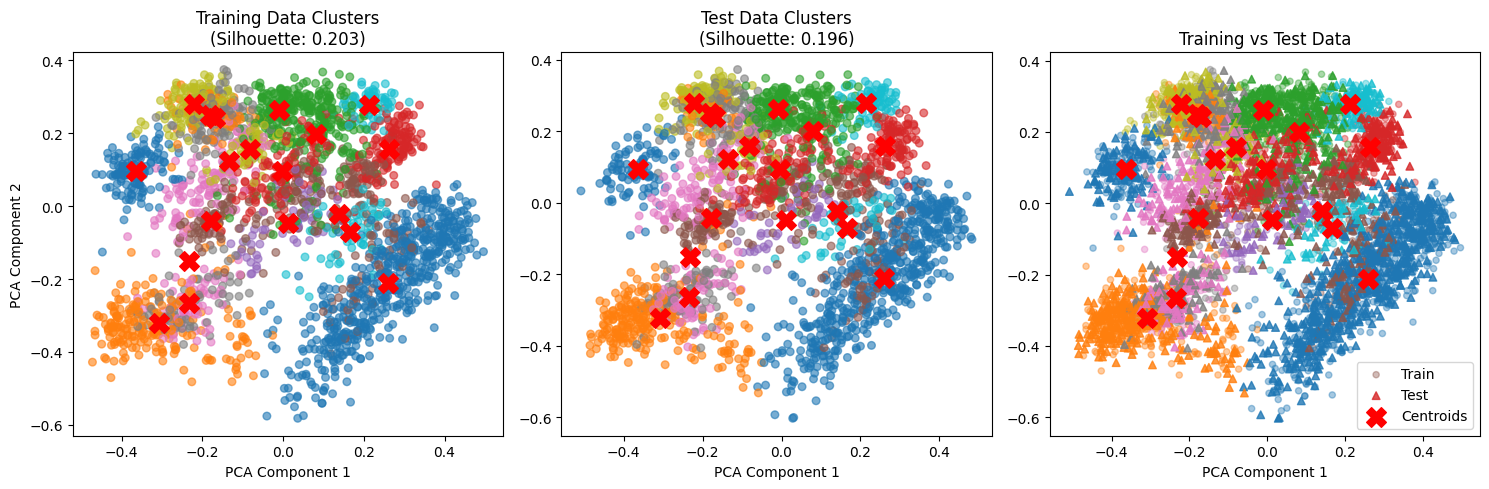

In [34]:
# Cell 10: Test Set Cluster Visualization
test_2d = pca.transform(role_jobdesc_embeddings_test)

plt.figure(figsize=(15, 5))

# Training data plot
plt.subplot(1, 3, 1)
scatter1 = plt.scatter(train_2d[:,0], train_2d[:,1], c=train_labels, cmap='tab10', alpha=0.6, s=30)
plt.scatter(centroids_2d[:,0], centroids_2d[:,1], c='red', marker='X', s=200)
plt.title(f"Training Data Clusters\n(Silhouette: {train_silhouette:.3f})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

# Test data plot
plt.subplot(1, 3, 2)
scatter2 = plt.scatter(test_2d[:,0], test_2d[:,1], c=test_labels, cmap='tab10', alpha=0.6, s=30)
plt.scatter(centroids_2d[:,0], centroids_2d[:,1], c='red', marker='X', s=200)
plt.title(f"Test Data Clusters\n(Silhouette: {test_silhouette:.3f})")
plt.xlabel("PCA Component 1")

# Combined plot
plt.subplot(1, 3, 3)
plt.scatter(train_2d[:,0], train_2d[:,1], c=train_labels, cmap='tab10', alpha=0.4, s=20, label='Train')
plt.scatter(test_2d[:,0], test_2d[:,1], c=test_labels, cmap='tab10', alpha=0.8, s=30, marker='^', label='Test')
plt.scatter(centroids_2d[:,0], centroids_2d[:,1], c='red', marker='X', s=200, label='Centroids')
plt.title("Training vs Test Data")
plt.xlabel("PCA Component 1")
plt.legend()

plt.tight_layout()
plt.show()

In [35]:
# Cell 11: Comprehensive Test Evaluation
print("COMPREHENSIVE TEST EVALUATION")
print("=" * 50)

# Cosine similarity comparison between train and test
train_similarities = [
    cosine_similarity(resume_embeddings_train[i].reshape(1, -1), 
                     role_jobdesc_embeddings_train[i].reshape(1, -1))[0][0]
    for i in range(len(resume_embeddings_train))
]

test_similarities = [
    cosine_similarity(resume_embeddings_test[i].reshape(1, -1), 
                     role_jobdesc_embeddings_test[i].reshape(1, -1))[0][0]
    for i in range(len(resume_embeddings_test))
]

print("Cosine Similarity Comparison (Resume ↔ Job Description):")
print(f"Train Avg: {np.mean(train_similarities):.4f} ± {np.std(train_similarities):.4f}")
print(f"Test Avg:  {np.mean(test_similarities):.4f} ± {np.std(test_similarities):.4f}")

# Sample examples from test set
print(f"\nSample Test Examples:")
sample_indices = random.sample(range(len(test_similarities)), min(5, len(test_similarities)))
for idx in sample_indices:
    cluster_id = test_labels[idx]
    sim_score = test_similarities[idx]
    print(f"Test Sample {idx} | Cluster: {cluster_id} | Similarity: {sim_score:.4f}")

# Test similarity by cluster
print(f"\nTest Similarity by Cluster:")
for cluster_id in range(best_k):
    cluster_mask = test_labels == cluster_id
    if np.any(cluster_mask):
        cluster_sims = np.array(test_similarities)[cluster_mask]
        print(f"Cluster {cluster_id}: {np.mean(cluster_sims):.4f} ± {np.std(cluster_sims):.4f} (n={len(cluster_sims)})")

# Distance to centroids analysis
print(f"\nDistance to Centroids Analysis:")
train_distances = []
for i in range(len(X_train_embeddings)):
    distances = [np.linalg.norm(X_train_embeddings[i] - centroid) for centroid in kmeans.cluster_centers_]
    train_distances.append(np.min(distances))

test_distances = []
for i in range(len(role_jobdesc_embeddings_test)):
    distances = [np.linalg.norm(role_jobdesc_embeddings_test[i] - centroid) for centroid in kmeans.cluster_centers_]
    test_distances.append(np.min(distances))

print(f"Train Avg Distance to Nearest Centroid: {np.mean(train_distances):.4f} ± {np.std(train_distances):.4f}")
print(f"Test Avg Distance to Nearest Centroid: {np.mean(test_distances):.4f} ± {np.std(test_distances):.4f}")

if np.mean(test_distances) <= np.mean(train_distances) * 1.2:
    print("✓ Test data fits well within learned cluster structure")
else:
    print("⚠ Test data seems more distant from centroids than training data")

COMPREHENSIVE TEST EVALUATION
Cosine Similarity Comparison (Resume ↔ Job Description):
Train Avg: 0.9779 ± 0.0126
Test Avg:  0.9777 ± 0.0128

Sample Test Examples:
Test Sample 416 | Cluster: 16 | Similarity: 0.9774
Test Sample 496 | Cluster: 3 | Similarity: 0.9813
Test Sample 802 | Cluster: 1 | Similarity: 0.9536
Test Sample 2212 | Cluster: 2 | Similarity: 0.9769
Test Sample 1794 | Cluster: 0 | Similarity: 0.9846

Test Similarity by Cluster:
Cluster 0: 0.9838 ± 0.0092 (n=542)
Cluster 1: 0.9850 ± 0.0106 (n=98)
Cluster 2: 0.9801 ± 0.0111 (n=262)
Cluster 3: 0.9668 ± 0.0110 (n=53)
Cluster 4: 0.9741 ± 0.0090 (n=125)
Cluster 5: 0.9804 ± 0.0101 (n=183)
Cluster 6: 0.9630 ± 0.0254 (n=121)
Cluster 7: 0.9838 ± 0.0074 (n=121)
Cluster 8: 0.9739 ± 0.0100 (n=52)
Cluster 9: 0.9726 ± 0.0110 (n=83)
Cluster 10: 0.9772 ± 0.0118 (n=195)
Cluster 11: 0.9733 ± 0.0092 (n=137)
Cluster 12: 0.9747 ± 0.0098 (n=65)
Cluster 13: 0.9709 ± 0.0101 (n=78)
Cluster 14: 0.9735 ± 0.0111 (n=128)
Cluster 15: 0.9707 ± 0.0149 (n

In [36]:
# Cell 12: Save Artifacts and Final Summary
# Save the trained model
joblib.dump(kmeans, "kmeans_model.pkl")
print("✓ KMeans model saved as 'kmeans_model.pkl'")

# Print final comprehensive summary
print("\n" + "="*60)
print("FINAL TRAINING & TESTING SUMMARY")
print("="*60)
print(f"Dataset split: 50% used (40% train, 10% test), 50% unused")
print(f"Training samples: {len(train)}")
print(f"Testing samples: {len(test)}")
print(f"Optimal number of clusters: {best_k}")
print(f"Training silhouette score: {train_silhouette:.4f}")
print(f"Test silhouette score: {test_silhouette:.4f}")
print(f"Generalization gap: {abs(train_silhouette - test_silhouette):.4f}")
print(f"Train avg cosine similarity: {np.mean(train_similarities):.4f}")
print(f"Test avg cosine similarity: {np.mean(test_similarities):.4f}")
print(f"Model and all artifacts saved successfully!")

# Performance assessment
if test_silhouette > 0.3:
    print("✓ Good clustering performance on test data")
elif test_silhouette > 0.1:
    print("~ Moderate clustering performance on test data")
else:
    print("⚠ Low clustering performance - consider more clusters or different features")

✓ KMeans model saved as 'kmeans_model.pkl'

FINAL TRAINING & TESTING SUMMARY
Dataset split: 50% used (40% train, 10% test), 50% unused
Training samples: 2543
Testing samples: 2544
Optimal number of clusters: 19
Training silhouette score: 0.2029
Test silhouette score: 0.1963
Generalization gap: 0.0066
Train avg cosine similarity: 0.9779
Test avg cosine similarity: 0.9777
Model and all artifacts saved successfully!
~ Moderate clustering performance on test data
